In [40]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from model_suport import load_best_score, plot_confusion_matrix_with_labels, generate_predictions_csv
import optuna
import os
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Cell 2: Carregamento dos dados
data = pd.read_csv('../process/Main_Versao/DF_1_After_Pre_Processamento.csv') 
data_test = pd.read_csv('../process/Main_Versao/DF_Test_1_After_Pre_Processamento.csv')

label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
#    'CN-MCI' : 4
}
# Separação das features e do target
X = data.drop('Transition', axis=1)
y = data['Transition']

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)

# Obtenção do melhor score anterior
best_score, _ = load_best_score()

Current Best Score Stored: 45.42528735632183867210%
Model with Best Score: RandomForestClassifier



In [41]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

TPE 

In [42]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 200, 800)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [False, True])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy','log_loss'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    model1 = ExtraTreesClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        class_weight = class_weight,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=34
    )

    scores_5 = cross_val_score(model1, X_train, y_train, cv=5, scoring='f1_macro')
    accuracy_5 = scores_5.mean()

    return accuracy_5


In [43]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)
print(f"Melhor acurácia: {study.best_value}")
print(f"Melhores hiperparâmetros: {study.best_params}")


[I 2024-11-27 15:26:48,022] A new study created in memory with name: no-name-b1984941-e774-402a-8dd8-2e76319f3b51
[I 2024-11-27 15:26:49,104] Trial 0 finished with value: 0.3864067657662963 and parameters: {'n_estimators': 206, 'max_features': 'sqrt', 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 8, 'bootstrap': False, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3864067657662963.
[I 2024-11-27 15:26:50,725] Trial 1 finished with value: 0.3379754105982113 and parameters: {'n_estimators': 508, 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'log_loss', 'class_weight': None}. Best is trial 0 with value: 0.3864067657662963.
[I 2024-11-27 15:26:52,815] Trial 2 finished with value: 0.4015238125908656 and parameters: {'n_estimators': 397, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'entrop

Melhor acurácia: 0.41900267787472567
Melhores hiperparâmetros: {'n_estimators': 265, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 8, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}


Resultados

In [44]:

# *? ###################################################################################################################################################################
# *?     ACCURACY    ##          DataSet        ##      Parametros
# *? ###################################################################################################################################################################
# *?  0.5157575      ##   5 data apos 1_2 sem des ##  {'n_estimators': 997, 'max_features': 'log2', 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}
# *?  0.520101010    ##   5 data apos 1_2 sem des ## {'n_estimators': 994, 'max_features': 'log2', 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}
# *? 0.51565656565   ## 5 data apos 1_2 sem des    ## {'n_estimators': 946, 'max_features': 'log2', 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}

In [45]:

# *? ###################################################################################################################################################################
# *?     F1_MACRO_Cross    ##          DataSet        ##      Parametros
# *? ###################################################################################################################################################################
# *?   0.43147             ##  DF_1_After_Pre_Processamento.csv   ## {'n_estimators': 472, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False}
# **   0.43206             ##  DF_1_After_Pre_Processamento.csv   ## {'n_estimators': 422, 'max_features': 'sqrt', 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini', 'class_weight': None}
# *? 

## Extra Trees  

### Score

F1_macro: 0.3769970904272175
              precision    recall  f1-score   support

           0       0.55      0.75      0.63        24
           1       0.50      0.47      0.48        15
           2       0.17      0.18      0.17        17
           3       0.33      0.17      0.22        18

    accuracy                           0.42        74
   macro avg       0.39      0.39      0.38        74
weighted avg       0.40      0.42      0.40        74



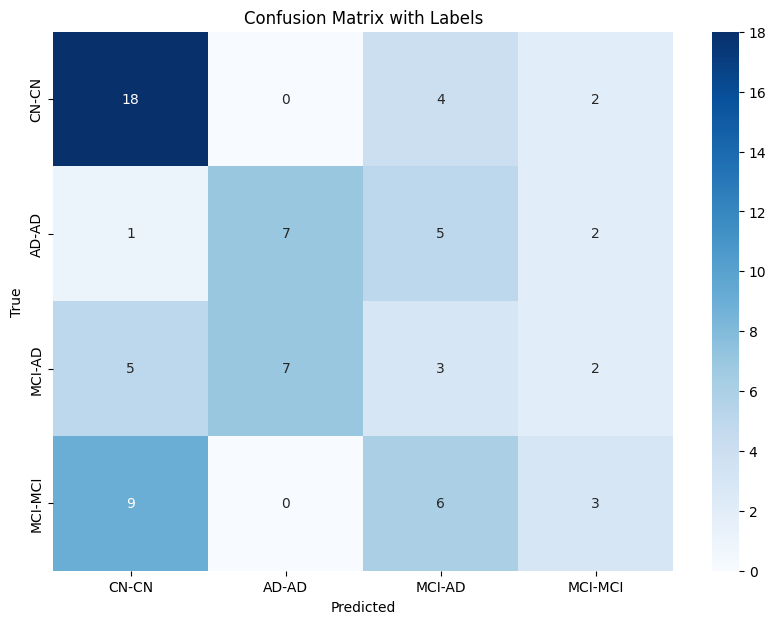

In [46]:
# Cell 5: Treinamento com os melhores parâmetros encontrados


ExtraTrees_model_score = ExtraTreesClassifier(
    n_estimators=447, max_features='sqrt', max_depth=15,
    min_samples_split=10, min_samples_leaf=5, bootstrap=False, random_state=34
)

ExtraTrees_model_score.fit(X_train, y_train)
et_pred = ExtraTrees_model_score.predict(X_test)
et_f1_macro = f1_score(y_test, et_pred, average='macro')
print("F1_macro:", et_f1_macro)
print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)




### Cross Validation Score F1_MACRO

In [47]:
ExtraTrees_model_cross_valition_score = ExtraTreesClassifier(
    n_estimators=447, max_features='sqrt', max_depth=15,
    min_samples_split=10, min_samples_leaf=5, bootstrap=False, random_state=34
)

et_f1_macro_score = cross_val_score(ExtraTrees_model_cross_valition_score, X_train, y_train, cv=5,scoring='f1_macro')

print(f"F1 Macro score: {et_f1_macro_score.mean()}")
print(f"F1 Macro score deviation: {et_f1_macro_score.std()}")


F1 Macro score: 0.4266636631309459
F1 Macro score deviation: 0.0569735825548716


### Cross Validation Score Balance Accuracy 

In [48]:
ExtraTrees_model_balance_accuracy_score = ExtraTreesClassifier(
    n_estimators=447, max_features='sqrt', max_depth=15,
    min_samples_split=10, min_samples_leaf=5, bootstrap=False, random_state=34
)

et_balance_accuracy_score = cross_val_score(ExtraTrees_model_cross_valition_score, X_train, y_train, cv=5,scoring='balanced_accuracy')

print(f"F1 Macro score: {et_balance_accuracy_score.mean()}")
print(f"F1 Macro score deviation: {et_balance_accuracy_score.std()}")

F1 Macro score: 0.4518398268398268
F1 Macro score deviation: 0.053294035522644105


In [49]:



#generate_predictions_csv(ExtraTrees_model_score,     data_test          )# If the new best score is higher, update the file




